Il codice nella cella seguente **deve essere eseguito**, ma **non deve essere modificato**, perché essenziale per un'esecuzione senza errori del successivo codice del laboratorio. Dopo averlo eseguito, attendi che il pallino adiacente ad R in alto a destra diventi bianco o che scompaia il simbolo [*].

In [1]:
#Esegui ma non modificare. Attendi  che scompaia il simbolo [*] 
#o che il pallino adiacente ad R in alto a destra diventi bianco
#potrebbe essere necessario qualche minuto
source('lib/preamble.R')

# Analisi delle componenti principali

In questa unità, ti mostrerò elementi aggiuntivi a quelli visti nel laboratorio di data visualization, e ti motiverò la necessità, nel caso di data set con molte variabili (multidimensionali), di tecniche più sofisticate di visualizzazione, esplorazione ed analisi. 
Le tecniche esplorate in questo laboratorio si riferiranno a soli set di dati numerici. Tuttavia, l'analisi delle componenti principali (PCA), che tratteremo come prima tecnica di apprendimento non supervisionato, può essere estesa anche a variabili di tipo ordinale o categorico, ma la sua trattazione, chiamata *analisi delle corrispondenze*, esula dagli scopi di questo corso. 


Ci appoggiamo per la visualizzazione ai pacchetti

In [2]:
library(tidyverse)
library(reshape2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




Con le seguenti istruzioni sei in grado di caricare il data set `GT` (Gross Tonnage) che contiene informazioni su $p=6$ variabili (lunghezza, larghezza, pescaggio, stazza, velocità massima e numero massimo di passeggeri) di $n=71$ navi cruise, riportate, rispettivamente sulle colonne del seguente data frame. Le righe sono ordinate in modo crescente in base alla prima variabile (lunghezza).

In [3]:
GTdataset <- read.csv("data/GTdataset_all.csv")
GTdataset<-GTdataset %>% arrange(Length) 
head(GTdataset)
n <- nrow(GTdataset)
p <- ncol(GTdataset)

,Length,Width,Draught,Gross.Tonnage,Max.Speed,Passengers
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,59.60,10.68,3.00,1206,13,52
2,65.96,11.50,3.50,1593,14,72
3,105.90,16.00,5.18,3849,13,94
4,142.10,18.00,4.80,10944,16,264
5,180.45,18.30,7.25,24318,27,927
6,180.45,25.50,7.25,24427,27,830


## Esplora il data set `GT`!

### Box plot
Rappresentiamo, in prima analisi, tutte le colonne tramite un box plot sullo stesso grafico.
Puoi usare il pratico comando `melt()` della libreria `reshape2` per rendere *tidy* il data set `GT` e visualizzare attraverso `ggplot()` il box plot di ogni variabile/colonna.

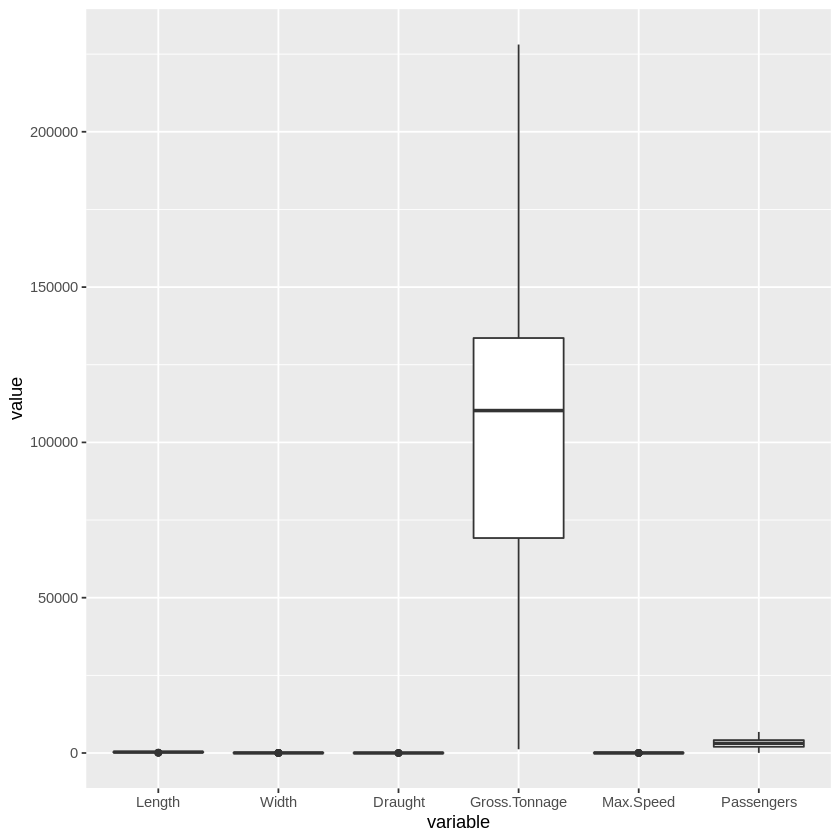

In [4]:
GTdataset %>% 
  melt(id.vars = NULL) %>% 
  ggplot(aes(variable, value)) + 
  geom_boxplot()

Puoi calcolare *Media*, *varianza* e *deviazione standard* campionarie di ogni variabile/colonna attraverso il seguente codice

In [5]:
apply(GTdataset, 2, mean) %>% round(1)
apply(GTdataset, 2, var) %>% round(1)
apply(GTdataset, 2, sd) %>% round(1)

Length         Width       Draught Gross.Tonnage     Max.Speed 
        277.9          34.5           7.8      101855.9          22.3 
   Passengers 
       3133.2

Length         Width       Draught Gross.Tonnage     Max.Speed 
       4041.0          65.9           1.4  2529651745.1           6.3 
   Passengers 
    3427705.7

Length         Width       Draught Gross.Tonnage     Max.Speed 
         63.6           8.1           1.2       50295.6           2.5 
   Passengers 
       1851.4

Osserva dal box plot (e dal corrispondente valore di varianza) che i valori di stazza (`Gross.Tonnage`) sono molto più variabili rispetto a quelli delle altre variabili, oltre ad avere una differente media.
Questa osservazione è legata principalmente all'unità di misura delle singole variabili. Se, per esempio, convertissimo la stazza (misurata in tonnellate, $t$) in chilotonnellate, $kt$, l'aspetto di questo grafico cambierebbe. 

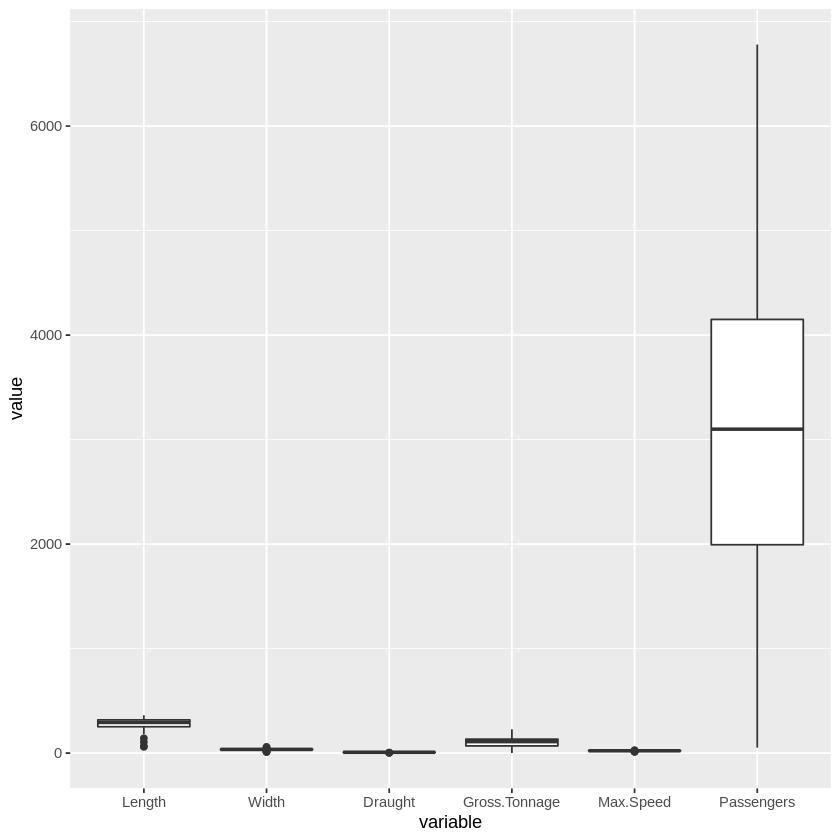

In [6]:
GTdataset %>% 
  mutate(Gross.Tonnage=Gross.Tonnage/10^3) %>%
  melt(id.vars = NULL) %>% 
  ggplot(aes(variable, value)) + 
  geom_boxplot()

Per poter ovviare al problema di effettuare analisi dipendenti dall'unità di misura, è praticamente sempre consigliabile *standardizzare* i dati.
Questa operazione si può facilmente implementare attraverso la funzione `scale()`, ottenendo così un data set adimensionale (l'unità di misura è la deviazione standard) e centrato intorno allo 0.
Ovviamente le variabili standardizzate avranno *media* nulla e *varianza* (*deviazione standard*) unitaria.

In [7]:
GTdataset_scaled <- GTdataset %>% scale() %>% as.data.frame()
round(apply(GTdataset_scaled, 2, mean))
apply(GTdataset_scaled, 2, var)
apply(GTdataset_scaled, 2, sd)

Length         Width       Draught Gross.Tonnage     Max.Speed 
            0             0             0             0             0 
   Passengers 
            0

Length         Width       Draught Gross.Tonnage     Max.Speed 
            1             1             1             1             1 
   Passengers 
            1

Length         Width       Draught Gross.Tonnage     Max.Speed 
            1             1             1             1             1 
   Passengers 
            1

Il box plot per il data set `GT` standardizzato è il seguente

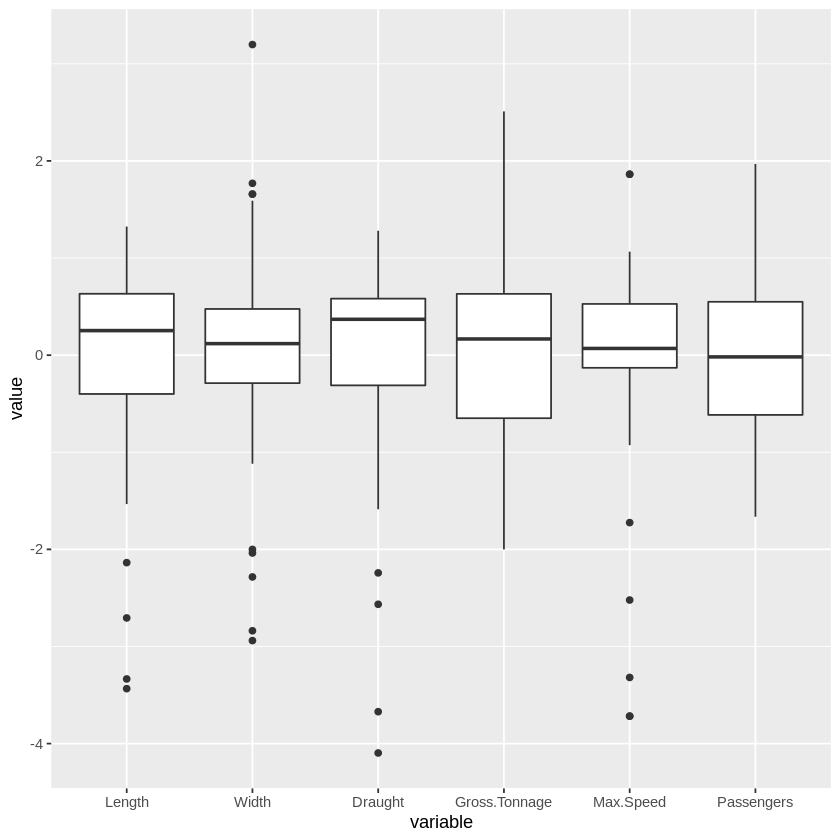

In [8]:
GTdataset_scaled %>% 
  melt(id.vars = NULL) %>% 
  ggplot(aes(variable, value)) + 
  geom_boxplot()

Tuttavia la rappresentazione mediante box plot è una mera visualizzazione, in una sola dimensione, di ogni singola colonna. 
Per migliorare l'analisi e sfruttare eventuali informazioni che si potrebbero desumere dall'analisi congiunta delle colonne, fai un passo in avanti e analizza le variabili del data set a coppie attraverso la matrice di grafici a dispersione o *scatter plot matrix*.  

### Analizza la matrice di grafici a dispersione
Attraverso la visualizzazione della matrice di grafici a dispersione puoi esplorare tutte le eventuali relazioni tra tutte le possibili coppie di variabili (numeriche). 
Come già visto nella scorsa lezione sulla visualizzazione dei dati, puoi ottenere la matrice di grafici a dispersione direttamente mediante il comando base `plot()`.

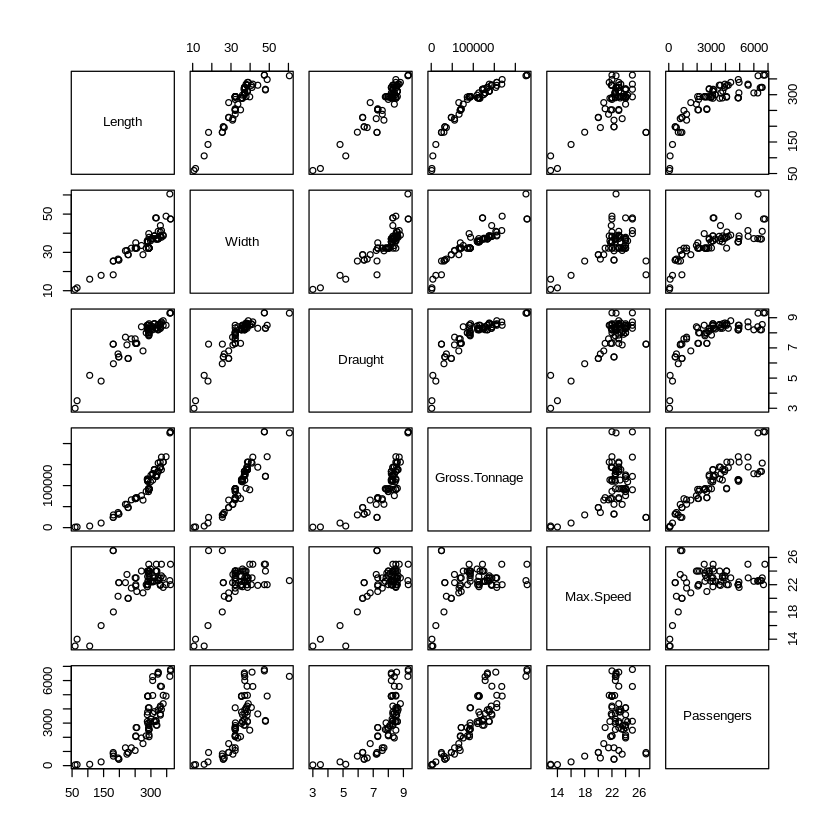

In [9]:
GTdataset %>% plot()

Oppure, come ricorderai dall'unità sulla data visualization della scorsa week, potresti usare il comando `ggpairs()` contenuto nel pacchetto `GGally`.

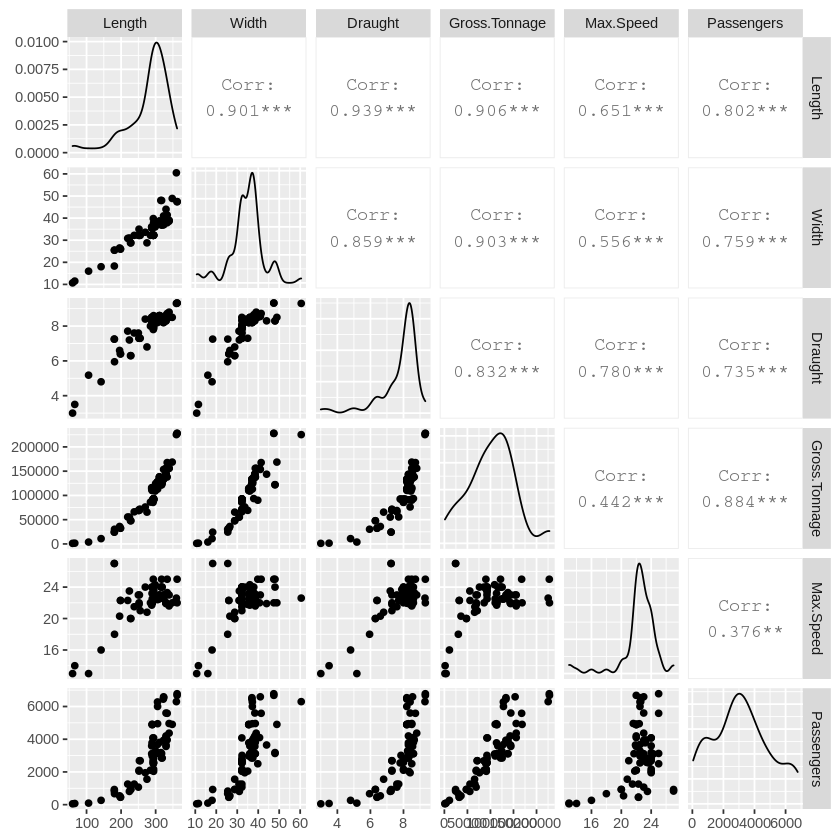

In [10]:
GTdataset %>% ggpairs(progress = FALSE)

Da subito si intuisce che questa visualizzazione è inefficiente se il numero delle variabili è molto elevato, come accade nei data set provenienti dall'Industria 4.0 o da qualsiasi altro contesto ad alta sensorizzazione e contenuto digitale. Tuttavia, è utile partire dal concetto di grafico a dispersione per visualizzare eventuali dipendenze, lineari e non, tra due variabili. 

Soffermati, per fissare le idee, sullo scatter plot tra la variabile `Draught` e `Length`, non standardizzate, per il momento.

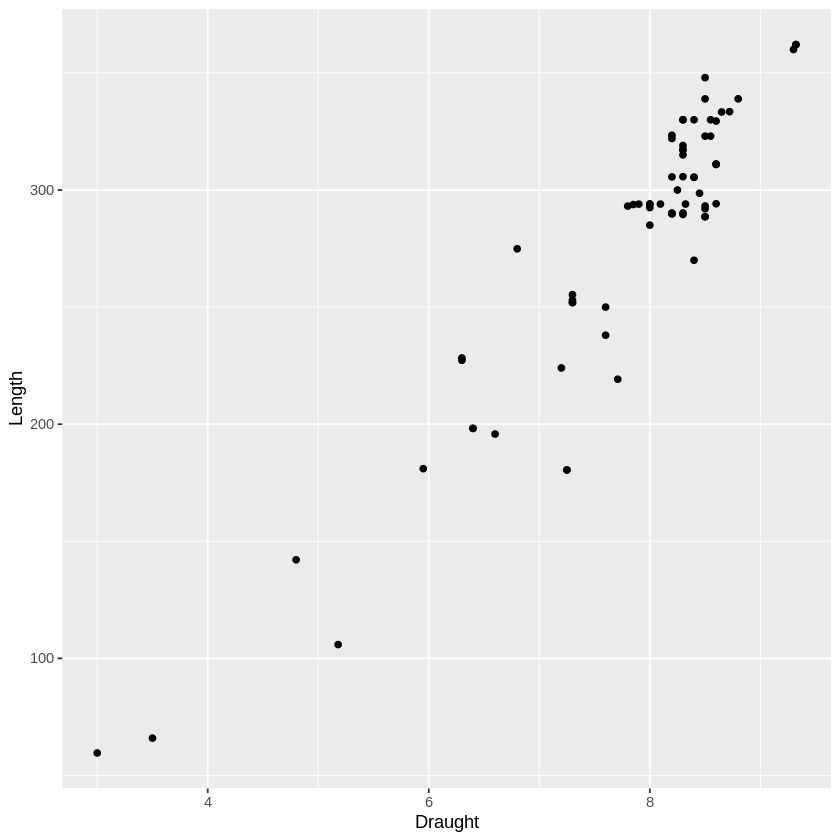

In [11]:
p <- GTdataset %>% 
  ggplot(aes(Draught, Length))+
  geom_point()
p

che possiamo diagrammare anche con la funzione `plot()`

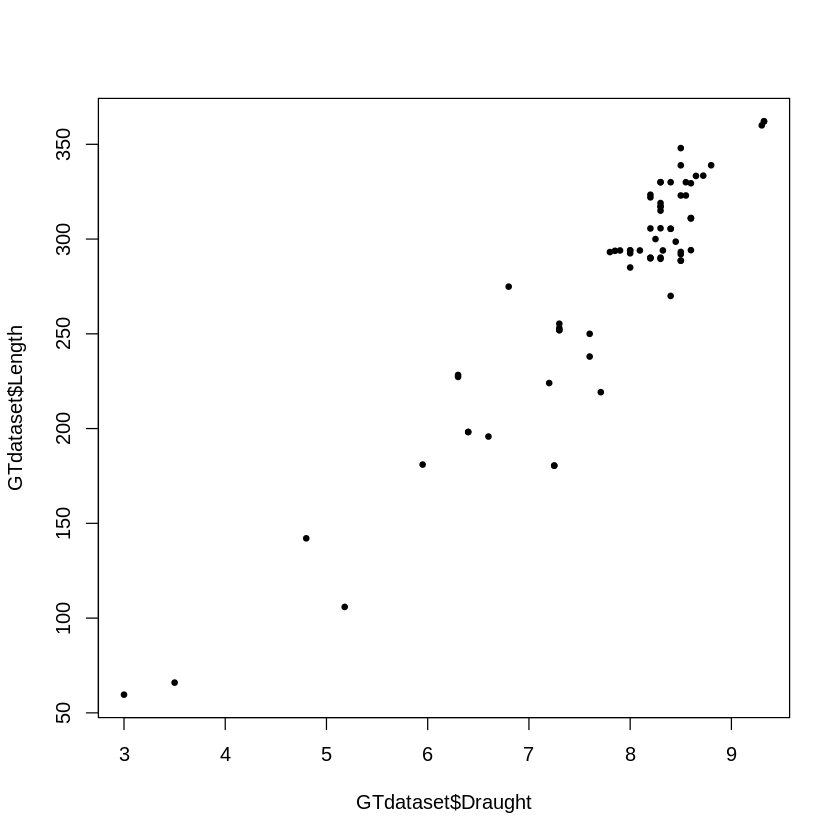

In [12]:
plot(GTdataset$Draught,GTdataset$Length, pch=19, cex=.6) #per avere punti pieni e più piccoli

Da questo grafico, è chiaro che esista una tendenza dei punti ad allinearsi secondo una retta con pendenza positiva. E quindi puoi concludere, per esempio, che navi con pescaggio (`Draught`) più elevato tendono ad avere una lunghezza dello scafo maggiore, mostrando un certo grado di dipendenza lineare. Come sappiamo, per misurare tale grado di dipendenza di una coppia di variabili, possiamo calcolare l'*indice di correlazione campionaria*, mediante la funzione `cor()`. Ricorda che l'indice di correlazione campionaria assume valori compresi tra -1 ed 1. Più il suo valore assoluto è prossimo all'unità, maggiore è il grado di dipendenza lineare tra le variabili in esame. 

In [13]:
cor(GTdataset$Draught,GTdataset$Length) %>% round(2)
cor(GTdataset$Draught,GTdataset$Draught)
cor(GTdataset$Length,GTdataset$Length)

[1] 0.94

[1] 1

[1] 1

Quindi, è intuitivo pensare, che 2 variabili con un alto $R$ possano essere ben approssimate da una retta e quindi che il problema iniziale, in apparenza bidimensionale nel piano $Draught-Length$, si sviluppi invece lungo una sola dimensione. Tuttavia, è bene subito notare che, soprattutto nel contesto dell'apprendimento non supervisionato, non c'è alcun nesso di causalità: non possiamo affermare quale tra le due variabili dipenda dall'altra. Tuttavia, possiamo senza dubbio osservare dai dati in esame (data-driven) che è possibile operare una *riduzione della dimensionalità*, ossia, per descrivere l'andamento delle variabili *lunghezza* e *pescaggio*, potrebbe bastare, approssimativamente, una sola dimensione. Tale dimensione viene chiamata *prima componente principale* (PC1). L'approssimazione è tanto migliore, quanto più alto è il valore di $R$ tra le variabili considerate.

##  Individua la prima componente principale!
A partire dai dati precedenti visualizza sul piano $Draught-Length$ la media (in rosso) 

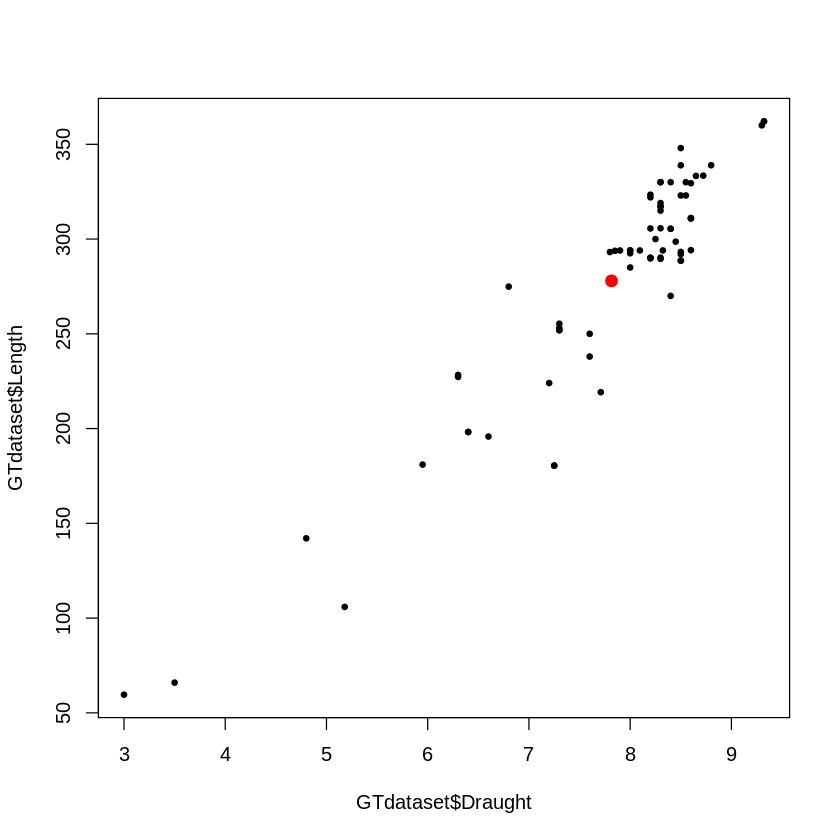

In [14]:
plot(GTdataset$Draught,GTdataset$Length, pch=19, cex=.6)
points(mean(GTdataset$Draught), mean(GTdataset$Length), col='red', pch=19,lwd=3)

e nota che un altro modo per dire che le variabili sono positivamente correlate è affermare che: se una variabile assume un valore minore (maggiore) della propria media, anche l'altra variabile tende ad assumere un valore minore (maggiore)  della propria media. Accade il viceversa, se invece le variabili sono correlate negativamente ($R$ con segno negativo).  Le proiezioni dei punti sui due assi coordinati possono essere, inoltre, visualizzate come segue (punti in rosso)

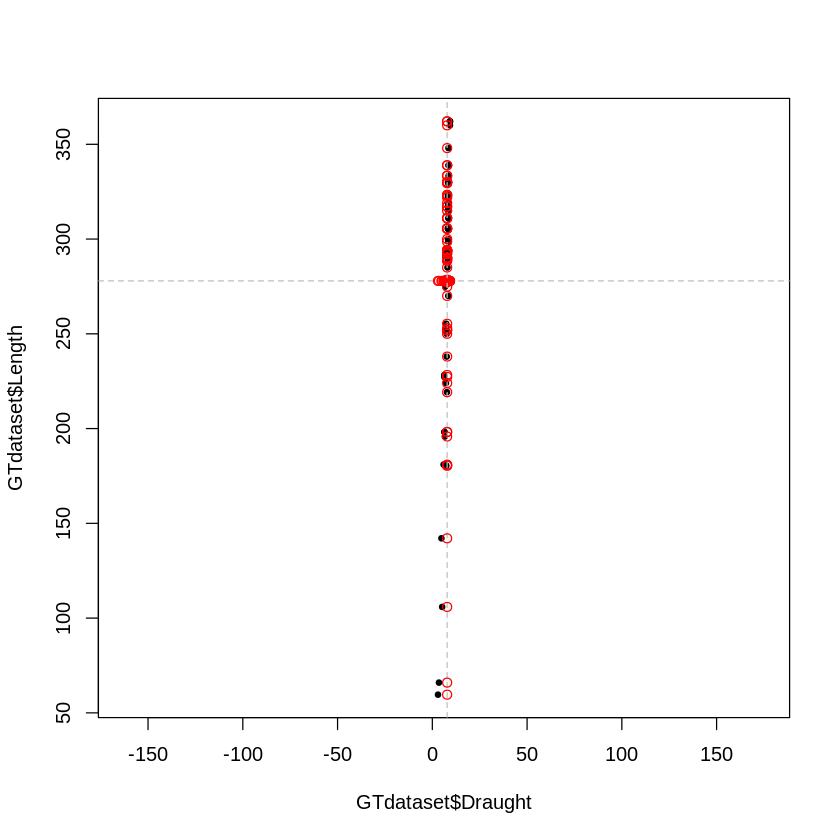

In [15]:
plot(GTdataset$Draught,GTdataset$Length, pch=19, cex=.6, asp =1)
points(mean(GTdataset$Draught), mean(GTdataset$Length), col='red', pch=19,lwd=3)

abline(h=mean(GTdataset$Length), lty=2, col='grey')
points(GTdataset$Draught, rep(mean(GTdataset$Length), n), col='red')

abline(v=mean(GTdataset$Draught), lty=2, col='grey')
points(rep(mean(GTdataset$Draught), n), GTdataset$Length, col='red')

La varianza delle due variabili è proprio pari alla dispersione di queste proiezioni intorno alla media e lungo gli assi coordinati.

In [16]:
apply(GTdataset %>% select(Draught,Length),2, var)

Draught      Length 
   1.381877 4041.002394

Osserva subito l'impatto della differente scala sui due assi! 
Anche a colpo d'occhio, la lunghezza (`Length`) ha una varianza (dispersione intorno alla propria media) maggiore del pescaggio (`Draught`). Per evitare che i risultati dipendano dall'unità di misura come già affermato, puoi standardizzare il data set e ripetere il grafico. 
In questo caso, le varianze lungo le direzioni degli assi coordinati risultano, come ci aspettavamo, entrambe pari a 1. L'utilizzo di `par(pty="s")`, all'inizio del codice, e dell'argomento `asp = 1`, all'interno del `plot` impongono al grafico ad avere la stessa scala sui due assi e l'usuale visualizzazione degli angoli nonché l'usuale inclinazione delle rette.
Una retta a 45° potrebbe, per esempio, senza questi accorgimenti, non presentarsi inclinata come ci aspettiamo.
Nota: per tornare alla visualizzazione dei grafici di default basterà usare il comando `dev.off()`

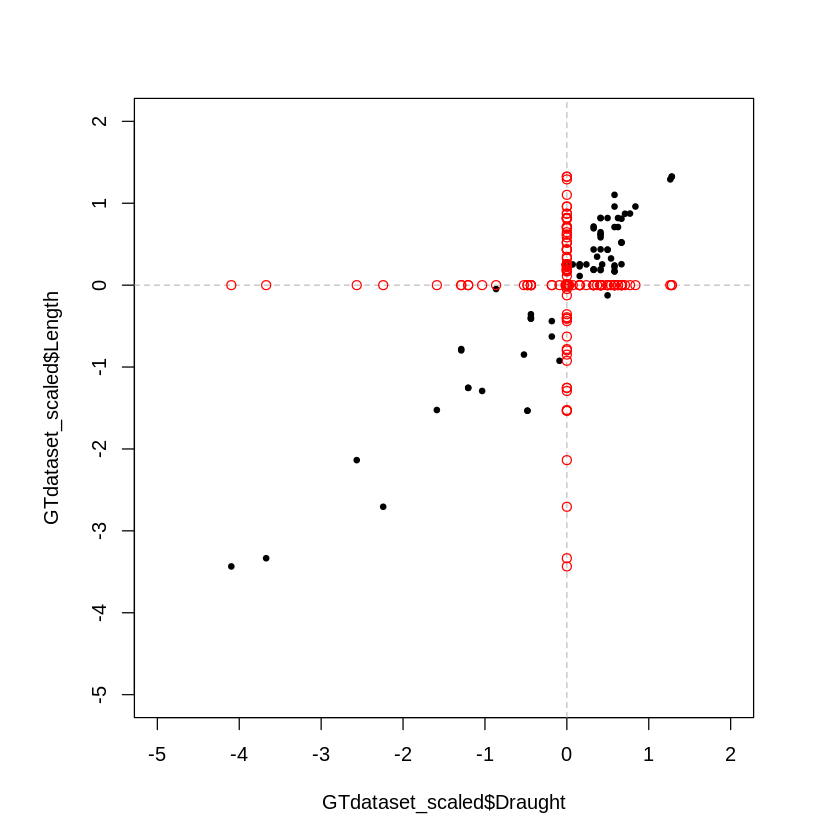

In [17]:
par(pty="s")
plot(GTdataset_scaled$Draught,GTdataset_scaled$Length, pch=19, cex=.6, ylim=c(-5,2), xlim=c(-5,2), asp=1)
points(mean(GTdataset_scaled$Draught), mean(GTdataset_scaled$Length), col='red', pch=19,lwd=3)

abline(h=mean(GTdataset_scaled$Length), lty=2, col='grey')
points(GTdataset_scaled$Draught, rep(mean(GTdataset_scaled$Length), n), col='red')

abline(v=mean(GTdataset_scaled$Draught), lty=2, col='grey')
points(rep(mean(GTdataset_scaled$Draught), n), GTdataset_scaled$Length, col='red')

Generalizzando il concetto, potresti ripetere il ragionamento e calcolare la varianza lungo una direzione qualsiasi. Per fare questo, costruisci un vettore (in radianti) di tutti gli angoli tra 0° e 360° con incrementi di 1°.

In [18]:
theta   <- seq(2*pi/360, 2*pi, by = 2*pi/360)

e usalo per tracciare una retta 

* passante per la media (pari al punto $(0,0)$ visto che abbiamo standardizzato il data set 
* con un angolo fissato dalla variabile `angle`, che ti invito a modificare nel blocco di codice seguente o nel prossimo **Ungraded Lab**. Nel codice seguente l'angolo è stato fissato a 45°.

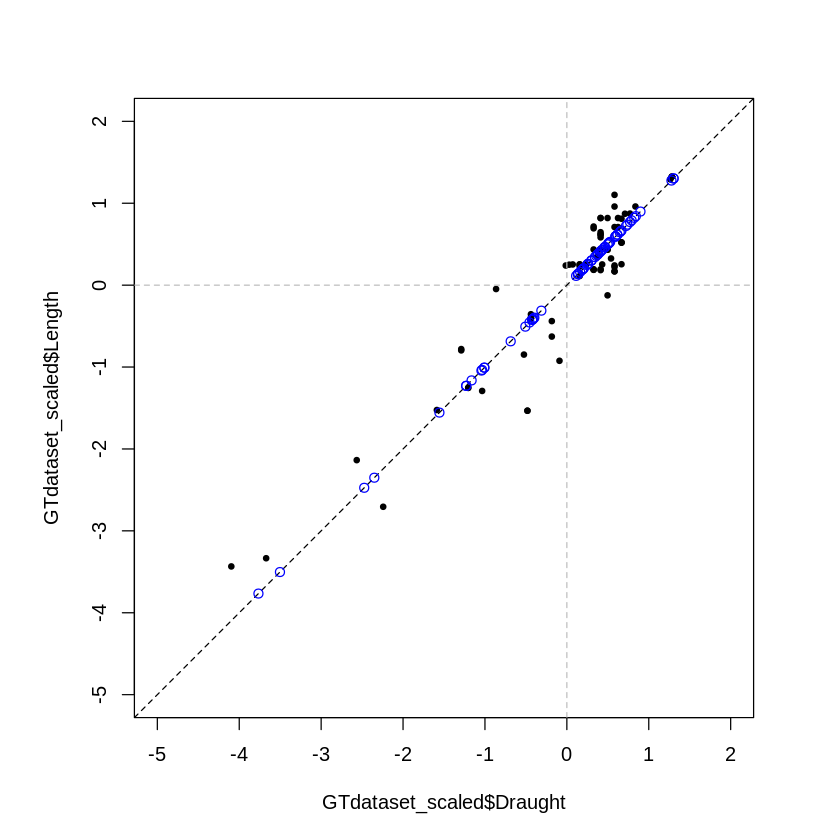

In [19]:
par(pty="s")
plot(GTdataset_scaled$Draught,GTdataset_scaled$Length, pch=19, cex=.6, ylim=c(-5,2), xlim=c(-5,2), asp=1)
abline(h=mean(GTdataset_scaled$Length), lty=2, col='grey')
abline(v=mean(GTdataset_scaled$Draught), lty=2, col='grey')

angle=theta[45]
abline(0, tan(angle), lty=2) #traccia una retta inclinata di un angolo `angle`
a <- c(cos(angle), sin(angle)) #vettore contenente la direzione della retta
proj=(GTdataset_scaled %>% select(Draught,Length) %>% as.matrix)%*%a  #modulo delle proiezioni lungo la direzione a
points(a[1]*proj, 
       a[2]*proj, col='blue') #coordinate delle proiezioni lungo la direzione a

Osserva che il vettore `a <- c(cos(angle), sin(angle))` (contenente la direzione della retta, nel codice appena mostrato) ha il quadrato della lunghezza o *norma* pari a 1.
Ricorda, qualsiasi sia l'angolo $\theta$, risulta la seguente relazione trigonometrica $\sin^2 (\theta)+\cos^2 (\theta)=1$.

La varianza lungo tale direzione è pari a 

In [20]:
var(proj) %>% as.numeric()

[1] 1.938855

È intuitivo, scegliere la PC1 come la direzione che totalizza la varianza maggiore delle proiezioni dei punti sperimentali su di essa. Si può dimostrare che la direzione individuata con questo criterio di ottimalità, è anche la direzione della retta che totalizza la minore somma dei quadrati delle distanze dei punti sperimentali.
Puoi facilmente scrivere del codice per ottenere questa direzione, esplorando, attraverso un ciclo `for`, tutte le direzioni del vettore `theta` definito sopra, e individuando la direzione `a` a cui corrisponde il più alto valore di  `var(proj)`.
Nota: il punto `.` in R non è una funzione d'accesso (come avviene in C++), quindi può essere usato come un qualsiasi altro carattere per denominare le variabili, alla stregua del carattere `_` o `-`.

In [21]:
Var     <- NULL #comincio a creare un vettore vuoto in cui registrare i valori di `var(proj)` per ogni direzione esplorata
for(i in 1:length(theta))  #for i che varia tra 1 e length(theta) ripeti:
{
  a   <- c(cos(theta[i]), sin(theta[i])) # vettore unitario nella direzione di theta[i]
  proj=(GTdataset_scaled %>% select(Draught,Length) %>% as.matrix)%*%a 
  Var <- c(Var, var(proj)) #aggiungi alla fine del vettore Var il valore var(proj)
}
max.var   <- max(Var)
max.theta <- theta[which.max(Var)]
max.a     <- c(cos(max.theta), sin(max.theta))

Per visualizzare graficamente il risultato dell'operazione precedente, puoi scrivere il seguente codice, che è di facile interpretazione se ti sono chiari i concetti finora esposti.

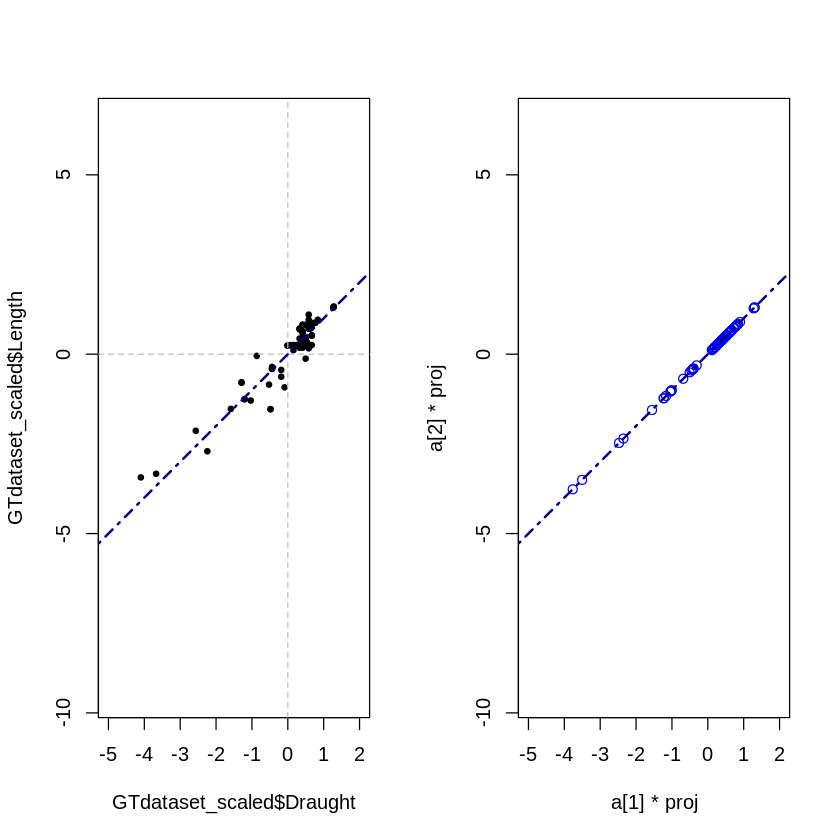

In [22]:
par(mfrow=c(1,2))
plot(GTdataset_scaled$Draught,GTdataset_scaled$Length, pch=19, cex=.6, ylim=c(-5,2), xlim=c(-5,2), asp=1)
abline(h=mean(GTdataset_scaled$Length), lty=2, col='grey')
abline(v=mean(GTdataset_scaled$Draught), lty=2, col='grey')
abline(0, tan(max.theta), lty = 4, col = 'navyblue', lwd = 2)

angle=max.theta

a <- max.a #vettore contenente la direzione della retta
proj=(GTdataset_scaled %>% select(Draught,Length) %>% as.matrix)%*%a #modulo delle proiezioni lungo la direzione max.a
plot(a[1]*proj, 
       a[2]*proj, col='blue', ylim=c(-5,2), xlim=c(-5,2), asp=1) #coordinate delle proiezioni lungo la direzione a
abline(0, tan(angle), lty=4, col = 'navyblue', lwd = 2) #traccia una retta inclinata di un angolo `angle`

Nel grafico a sinistra viene visualizzata la retta costruita lungo la prima componente principale `max.a` e a destra le proiezioni `proj` sulla PC1 dei punti sperimentali (`Draught`,`Length`). D'ora in poi chiameremo:

* *score* della PC1, i punti contenuti nel vettore `proj` rappresentati in blu
* *loading* della variabile `Draught` sulla PC1, il valore di `max.a[1]`
* *loading* della variabile `Length` sulla PC1, il valore di `max.a[2]`.
* *prima componente principale (PC1)* il vettore `max.a`.

Nota storica: è molto comune l'uso del termine PC1 per indicare gli score della PC1 e non il vettore dei loading `max.a`, che dal punto di vista didattico appare invece la scelta più naturale.

Osserva subito che, a meno di approssimazioni numeriche, la media degli score è 0  

In [23]:
round(mean(proj))

[1] 0

e la varianza è pari a `max.var`.

In [24]:
var(proj)
max.var

1.938855


[1] 1.938855

## Analisi delle componenti principali mediante pacchetto `stats` 
### Caso $p=2$

Per calcolare la PC1, ottenuta manualmente attraverso il codice presentato nel precedente esempio, puoi usare in modo pratico le funzioni `prcomp()` o `princomp()`, entrambe incluse nel pacchetto `stats`.
Dal punto di vista matematico sono abbastanza equivalenti. 
Prima di cominciare, puoi, come al solito, visualizzarne la documentazione tramite il comando `?prcomp`. 
Osserva che, come ogni funzione, `prcomp()` restituisce in uscita un oggetto con più campi. La classe di questo oggetto è di tipo `prcomp` (ma il nome poco importa!) che è essenzialmente una lista di elementi (eterogenei), che esploreremo in dettaglio di seguito. 
La cosa più importante, in primo luogo, è salvare questo oggetto in una variabile, che, nell'esempio che segue, decido di chiamare `pr.out` (ma avrei potuto usare qualsiasi altro nome).

In [25]:
pr.out <- GTdataset_scaled %>% select(Draught, Length) %>% prcomp()

Invece di utilizzare il data set scalato `GTdataset_scaled`, con l'argomento `scale=TRUE` puoi utilizzare direttamente il data set iniziale `GTdataset`.

In [26]:
pr.out <- GTdataset %>% select(Draught, Length) %>%  prcomp (scale = TRUE)

Il valore predefinito dell'argomento `scale=` di `prcomp()` è `FALSE`, come puoi leggere dalla documentazione.

Esplora quindi gli argomenti contenuti nella variabile `pr.out` con il comando

In [27]:
names(pr.out)

[1] "sdev"     "rotation" "center"   "scale"    "x"

Esaminiamo prima gli argomenti `center` e `scale`

In [28]:
pr.out$center %>% round(2)
pr.out$scale %>% round(2)

Draught  Length 
   7.82  277.92

Draught  Length 
   1.18   63.57

che per ogni colonna del data set rappresentano i valori di media e deviazione standard, con cui sono state standardizzate le singole osservazioni e rappresentano una descrizione statistica sintetica delle singole variabili/colonne. Equivalgono all'output del codice

In [29]:
apply(GTdataset %>% select(Draught, Length), 2, mean) %>% round(2)
apply(GTdataset %>% select(Draught, Length), 2, sd) %>% round(2)

Draught  Length 
   7.82  277.92

Draught  Length 
   1.18   63.57

e non hanno nulla a che vedere strettamente con la PCA. 

I loading delle variabili `Draught` e `Length` sulla PC1, gli score e la varianza della PC1 sono invece restituiti, nell'ordine, dalla prima colonna della matrice `pr.out$rotation`.

In [30]:
#loading sulla PC1
pr.out$rotation[,1]  %>% round(2)
#equivalente a max.a

Draught  Length 
   0.71    0.71

In [31]:
#score della PC1
pr.out$x[,1]%>% round(2)
#equivalente a proj[,1]

[1] -5.33 -4.95 -3.50 -3.32 -1.42 -1.42 -2.20 -1.64 -1.74 -1.74 -0.72 -0.97
[13] -1.48 -1.46 -0.57 -0.44 -0.60 -0.60 -0.59 -0.56  0.26 -0.64  0.19  0.53
[25]  0.53  0.42  0.36  0.37  0.37  0.43  0.57  0.27  0.16  0.58  0.20  0.23
[37]  0.29  0.48  0.29  0.35  0.65  0.61  0.51  0.66  0.66  0.54  0.60  0.84
[49]  0.84  0.84  0.70  0.73  0.73  0.75  0.72  0.94  0.91  0.74  1.04  0.93
[61]  0.87  0.87  1.02  1.12  1.16  1.09  1.27  1.19  1.81  1.84  1.84

In [32]:
#varianza della PC1
pr.out$sdev[1]^2 %>% round(2)
#equivalente a max.var

[1] 1.94